# Swapping Cell types
Alyssa's 11/6

Can we swap out different cell types in train/test and get similar accuracy?

Relevent Topics/references
- Snail
- metalearning

# Imports

In [192]:
import collections

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from scipy import stats

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

# Define Paths for this user

In [193]:
# ########################## PATHS ###########################
# # path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# # data processing


deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"
# dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
# feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

# _DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# # DNase filepath dictionary
# prefix_ =  "/data/akmorrow/encode_data/"

# # get TF logger
# log = logging.getLogger('tensorflow')
# tf_log = "/home/eecs/akmorrow/epitome/dnase/tensorflow_combination.log"
# fh = logging.FileHandler(tf_log)
# fh.setLevel(logging.INFO)
# log.addHandler(fh)

In [198]:
# PATH REQUIRED IN FILES
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"
exec(open("./constants.py").read())
exec(open("./models.py").read())
exec(open("./functions.py").read())
exec(open("./generators.py").read())

# Load Data

### Load DeepSEA data

In [196]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)


In [197]:
print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4455024, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4455024) (919, 455024)


# Choose cell types and assays

# Choose celltypes

Here we use p300, because we need at least 8 cell types:
- 3 for features in train
- 1 for validation
- 3 new for features in test
- 1 for test in both cases

In [188]:
train_f_celltypes = ['K562', 'HepG2', 'HeLa-S3']
test_f_celltypes = ['H1-hESC', 'GM12878', 'A549']
test_celltypes = ['SK-N-SH_RA']
validation_cell_types = ['T-47D']

all_eval_cell_types = validation_cell_types + test_celltypes

# Get cell, assay matrix for training

['T-47D', 'SK-N-SH_RA', 'K562', 'HepG2', 'HeLa-S3', 'H1-hESC', 'GM12878', 'A549'] ['DNase', 'p300', 'CTCF']


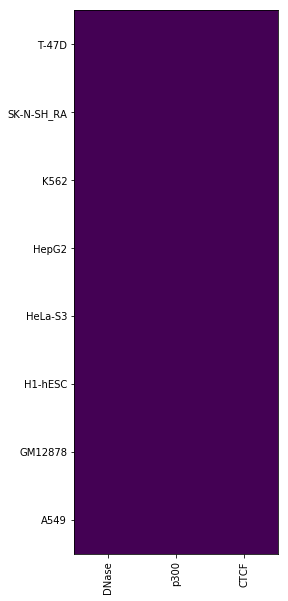

In [189]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', eligible_assays = ["p300", "CTCF"], 
                                 eligible_cells = train_f_celltypes + test_f_celltypes + all_eval_cell_types , min_assays=2)
        
inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys()), list(assaymap.keys()))

# Select train, valid and test cell types

- test on SK-N-SH_RA
- train/validate on T-47D
- use remaining cell types as feature input 

# Test Data Generator for shuffling cell types

In [150]:
def gen_from_peaks_shuffle_cell_types(data, y_index_vectors, assay_indices, dnase_indices, indices, radii, **kwargs):
    """
    Takes Deepsea data and calculates distance metrics from cell types whose locations
    are specified by y_index_vector, and the other cell types in the set. Label space is only one assay.
    This generator is used to test single vs multilabel classification performance.
    
    :param data: dictionary of matrices. Should have keys x and y. x contains n by 1000 rows. y contains n y 919 labels.
    :param y_index_vectors: list of vectors which the indices in the y labels that should be used. 
    :param assay_indices: list of assays that should be used in the label space.
    :param dnase_indices: indices for DNase for celltypes
    :param indices: indices of cell types for the feature space (does not include cell types for eval/test)
    :param radii: where to calculate DNase similarity to.
    
    :returns: generator of data
    """
    # y indices for x and assay indices for y should have the same length
    assert len(y_index_vectors) == len(assay_indices), "Length of y_index_vectors and assay_indices must be the same (# cells evaluatated)"
    
    batch_size = kwargs["batch_size"]
    matrix = kwargs["matrix"]
    all_eval_cell_types = kwargs["all_eval_cell_types"]
    
    def g():
                    
        if (len(radii) > 0):
            range_ = range(max(radii), data["y"].shape[-1]-max(radii))
        else: 
            range_ = range(0, data["y"].shape[-1])
            
        rec_count = 0
 
        for i in range_: # for all records
            
            for (y_index, assay_index) in zip(y_index_vectors, assay_indices):
                dnases = [] 
                
                # if new batch, permute the cell type orders
                if (rec_count % batch_size == 0):
                    # shuffle the rows, which are the training cell types
                    all_eval_cell_type_indices = list(map(lambda c: cellmap[c], all_eval_cell_types))
                    indices_mat = np.delete(matrix, all_eval_cell_type_indices, axis=0)
                    
                    # shuffle cell types
                    np.random.shuffle(indices_mat)

                    # get all feature locations for DNase for remaining cell types (just the first column in matrix)
                    dnase_indices = indices_mat[:,0] # for all of the cell types (including the cell type we are evaluating)
                    indices = indices_mat[indices_mat!=-1] # remaining indices for cell types not in evaluation or or test

                for radius in radii:
                    
                    # within the radius, fraction of places where they are both 1
                    # y_index[0] == DNase location for specific cell type
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    
                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                    
                rec_count += 1
                    
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                assay_index_no_dnase = np.delete(assay_index, [0])
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][assay_index_no_dnase,i] 
    return g

In [142]:
exec(open("./generators.py").read())
x = make_dataset(train_data,
                 validation_cell_types,
                 all_eval_cell_types + test_f_celltypes,
                 gen_from_peaks_shuffle_cell_types,
                 matrix,
                 assaymap,
                 cellmap,
                 64,
                 shuffle_size=2,
                 prefetch_size=10,
                 radii=[1,3,10,30])()

# Run with DNase

In [ ]:
exec(open("./generators.py").read())
exec(open("./models.py").read())

time = datetime.datetime.now().time().strftime("%Y-%m-%d_%H:%M:%S")

file = open('/data/akmorrow/epitome_data/out/tmp_prediction_metalearn_aucs_%s.py' % time, 'w')


model = MLP(4, [100, 100, 100, 50], 
        tf.tanh, 
        train_data, 
        valid_data, 
        test_data, 
        validation_celltypes,
        test_celltypes,
        gen_from_peaks_shuffle_cell_types, 
        matrix,
        assaymap,
        cellmap,
        shuffle_size=2, 
        all_eval_cell_types=all_eval_cell_types + test_f_celltypes,
        radii=[1,3,10,30])
model.train(20000)

test_DNase = model.test(455024, mode = Dataset.TEST, log=True)

# save to file
file.write('test set %f \n' % test_DNase[2])
file.flush()


_, new_data = make_dataset(test_data,
                 validation_cell_types,
                 all_eval_cell_types + train_f_celltypes,
                 gen_from_peaks_shuffle_cell_types,
                 matrix,
                 assaymap,
                 cellmap,
                 64,
                 shuffle_size=2,
                 prefetch_size=10,
                 radii=[1,3,10,30])

validation_holdout_indices = np.array([]) 
test_generator = model.test_from_generator(455024, new_data, validation_holdout_indices, log=True)


# save to file
file.write('test set with  new cell types %f \n' % test_generator[2])
file.flush()

INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.24026315
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8799671977142476
INFO:tensorflow:Our micro AUC:     0.9103550330603764
2018-12-06 15:38:31.775933 0 DNase
INFO:tensorflow:2018-12-06 15:38:31.776051: 0, DNase, NaN
INFO:tensorflow:2018-12-06 15:38:31.779297: 1, p300, 0.807498
INFO:tensorflow:2018-12-06 15:38:31.846041: 2, CTCF, 0.952436
INFO:tensorflow:
INFO:tensorflow:2000 0.2189306
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8342362975553606
INFO:tensorflow:Our micro AUC:     0.886069423729602
2018-12-06 15:40:25.997878 0 DNase
INFO:tensorflow:2018-12-06 15:40:25.999060: 0, DNase, NaN
INFO:tensorflow:2018-12-06 15:40:25.999935: 1, p300, 0.715492
INFO:tensorflow:2018-12-06 15:40:26.066426: 2, CTCF, 0.952981
INFO:tensorflow:
INFO:tensorflow:3000 0.3058772
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.8280842637065156
INFO:t